In [4]:
!pip install split-folders
!pip install skorch 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 KB 733.7 kB/s eta 0:00:00a 0:00:01


In [8]:
import os
import warnings
import torchvision
import torch
import matplotlib
import matplotlib.pyplot as plt
import splitfolders
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.helper import predefined_split

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [9]:
print(torch.__version__)

1.9.1+cpu


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
data_dir = '../input/braintumor/Datasets(2)'
classes = os.listdir(data_dir + "/Training")

print('Classes:')
for idx, train_class in enumerate(classes):
    print(f'{idx+1}. {train_class}')


Classes:
1. no_tumor
2. tumor


In [12]:
size_traning = 0

print('Datasets traning size:')
for idx,train_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Training/{train_class}"))
  size_traning += size
  print(f'{idx+1}. {train_class} {size}')
print(f'Sum {size_traning}')

Datasets traning size:
1. no_tumor 499
2. tumor 520
Sum 1019


In [13]:
splitfolders.ratio('../input/braintumor/Datasets(2)/Training', output='datsets', ratio=(0.8, 0.1003, 0.0997))

Copying files: 1019 files [00:05, 197.90 files/s]


In [14]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder('/kaggle/working/datsets/train/', transform=transform)
dataset_validating = ImageFolder('/kaggle/working/datsets/val/', transform=transform)
dataset_testing = ImageFolder('/kaggle/working/datsets/test/', transform=transform)

print(f'Size train {len(dataset_training)}')
print(f'Size val {len(dataset_validating)}')
print(f'Size test {len(dataset_testing)}')

Size train 815
Size val 102
Size test 102


In [15]:
img, label = dataset_training[0]
print(f'Input shape: {img.shape}')

Input shape: torch.Size([3, 224, 224])


In [16]:
batch_size=16
train_loader = DataLoader(dataset_training, batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

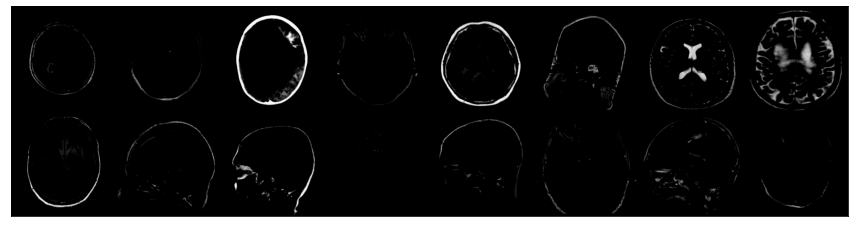

In [17]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

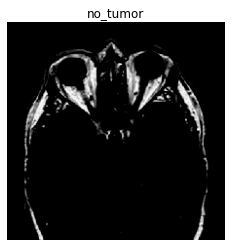

In [18]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[0])

In [19]:
y_test = np.array([label for x, y in iter(test_loader) for label in y])
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Pytorch and Skorch')
    y_prediction = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.set_title(f'Confusion Matrix {model} Pytorch and Skorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

In [21]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":['train_acc', 'valid_acc'],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch and Skorch - {model}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":['train_loss', 'valid_loss'],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch and Skorch - {model}',
                "ylabel":'Loss'
            }]
    
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(history[:, tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(history[:, tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [22]:
train_acc = EpochScoring(scoring='accuracy', on_train=True, 
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

In [23]:
class ModelMmobilenetV2(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.mobilenet_v2(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)
        
net_mobilenetv2 = NeuralNetClassifier(
    ModelMmobilenetV2,
    module__output_features=2,
    max_epochs=5,
    lr=0.001,
    batch_size=16,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [24]:
warnings.filterwarnings('ignore')
print('Train Mobilenetv2 Pytorch and Skorch')
net_mobilenetv2.fit(dataset_training, y=None)

Train Mobilenetv2 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss      dur
-------  -----------  ------------  -----------  ------------  -------
      1       0.7755        0.5103       0.5098        2.3700  96.8947
      2       0.8859        0.3187       0.8235        0.4362  76.6770
      3       0.8982        0.2328       0.6176        0.8774  76.8442
      4       0.9239        0.1938       0.4902        7.6161  76.7395
      5       0.9239        0.2173       0.7941        0.5251  76.3302


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelMmobilenetV2(
    (model): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
     

In [30]:
class ModelDenseNet121(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.densenet121(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)
       
net_densenet121 =  NeuralNetClassifier(
    ModelDenseNet121,
    module__output_features=2,
    max_epochs=5,
    lr=0.001,
    batch_size=16,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [31]:
warnings.filterwarnings('ignore')
print('Train DenseNet121 Pytorch and Skorch')
net_densenet121.fit(dataset_training, y=None)

Train DenseNet121 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss       dur
-------  -----------  ------------  -----------  ------------  --------
      1       0.7939        0.4600       0.8529        0.6856  235.1431
      2       0.8552        0.3903       0.8333        0.5041  235.3616
      3       0.8663        0.3386       0.8137        0.4484  236.5954
      4       0.8773        0.3206       0.8137        0.8400  235.7251
      5       0.8761        0.3178       0.4902        3.6620  234.9749


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelDenseNet121(
    (model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [33]:
class ModelResnet50(nn.Module):
      def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(num_classes=output_features, pretrained=False)
        self.model = model

      def forward(self, x):
        return self.model(x)

net_resnet50 =  NeuralNetClassifier(
    ModelResnet50,
    module__output_features=2,
    max_epochs=5,
    lr=0.001,
    batch_size=16,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(dataset_validating),
    callbacks=callbacks, 
    device=device,
    )

In [34]:
warnings.filterwarnings('ignore')
print('Train Resnet50 Pytorch and Skorch')
net_resnet50.fit(dataset_training, y=None)

Train Resnet50 Pytorch and Skorch
  epoch    train_acc    train_loss    valid_acc    valid_loss       dur
-------  -----------  ------------  -----------  ------------  --------
      1       0.7337        0.6459       0.6078        0.8052  258.9682
      2       0.8258        0.4478       0.7941        0.5183  261.1236
      3       0.8528        0.3950       0.5588        1.8529  259.1197
      4       0.8785        0.3567       0.8824        1.0522  259.8162
      5       0.8871        0.3154       0.5000        3.0652  259.2140


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ModelResnet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra